## Satellite data

In this exercise we will try to access and plot satellite-derived data.  This will more or less follow our lectures when using Matlab, but here we will use python.  To make things even more flexible, we will read data from remote data services (i.e., there will be no need to access data on the SOEST disks or download anything to your local machine).  As mentioned before, NASA PO.DAAC, the APDRC and PacIOOS are all good places to look for data.

Additionally, we will make use of the mapping functions within matplotlib.  This is just one way to draw coastlines; GeoPandas and cartopy are two others.

As usual, the first thing we want to do is import all the necessary packages:
<ul>
    <li> Numpy for numerical analysis and array handling
    <li> Matplotlib, pyplot for plots
    <li> mpl_toolkits for coastlines
    <li> netCDF4 to read the data from remote (OPeNDAP) servers
</ul>

In [1]:
# load array utils
import numpy as np

# load in plotting rountines
import matplotlib.pyplot as plt
%matplotlib inline  

# add mapping routines
from mpl_toolkits.basemap import Basemap

# import netcdf for working with OPeNDAP files
import netCDF4

# import pandas for data handling and dates
import pandas as pd

In [2]:
# load data
# In this example we read AVISO sea level from the APDRC OPeNDAP server:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/satellite_product/TOPEX/AVISO_reference/msla_monthly'
# url='https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/ww3_global/WaveWatch_III_Global_Wave_Model_best.ncd'

file = netCDF4.Dataset(url)

# optionally list variables
#print(file.variables)
# this shows us that we have variables lat, lon, sla and time.  We also see that
# sla (sea level anomaly) is a function of time(208 monthly means), lat(915 latitudes) and lon (1080 longitudes)

In [3]:
# extract lat, lon, and sea level anomaly at time=1
lat  = file.variables['lat'][:]
lon  = file.variables['lon'][:]
data = file.variables['sla'][1,:,:]
#data = file.variables['shgt'][1,0,:,:]

file.close()

<Figure size 432x288 with 0 Axes>

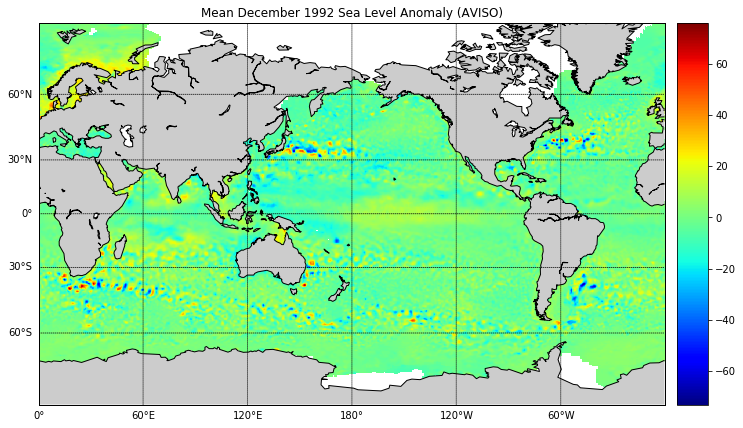

In [4]:
# draw color-shaded plot with map background

# set up the figure
plt.figure()

fig=plt.figure(figsize=(12, 8) )

# Miller projection:
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon.min(), \
  urcrnrlon=lon.max(),llcrnrlat=lat.min(),urcrnrlat=lat.max(), \
  resolution='c')

# convert the lat/lon values to x/y projections.
x, y = m(*np.meshgrid(lon,lat))

# plot the field using the fast pcolormesh routine 
# set the colormap to jet.

m.pcolormesh(x,y,data,shading='flat',cmap=plt.cm.jet)
m.colorbar(location='right')

# Add a coastline and axis values.

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
m.drawparallels(np.arange(-90.,90.,30.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

# Add a colorbar and title, and then show the plot.

plt.title('Mean December 1992 Sea Level Anomaly (AVISO)');

Now, let's try and extract a point near Hawaii (roughly 22N, 158W) and plot vs. all time.  Note since we closed the data set, we need to re-open and extract like last time.

In [5]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/satellite_product/TOPEX/AVISO_reference/msla_monthly'
file = netCDF4.Dataset(url)
time = file.variables['time']
lat  = file.variables['lat'][:]
lon  = file.variables['lon'][:]

In [6]:
# In Matlab we used "find" to look for point near 22N, 158W; recall that instead of
#  of looking for an exact point we looked for a range (again, remember we want one
#  and only one latitude and longitude).
# We do the same thing here, but numpy uses "argwhere"
J = np.argwhere((lat > 21.5) & (lat < 22.0))
I = np.argwhere((lon > 202) & (lon < 202.5))
data = file.variables['sla'][:,int(I),int(J)]

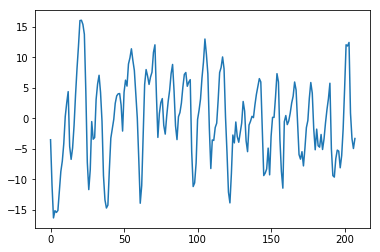

In [7]:
# Make a plot
plt.plot(data)

In [8]:
# Note that the x-axis is just sequential from 1 to 208, but what we really want
#  is time here (these are monthly mean values from December 1992).
# In python this becomes surprisingly easy.  We use the netCDF4 package to 
#  automatically read the time variable (see above) and then to convert from a 
#  number to a date.  All we need specify is the time units ("days since...") 
#  which we automatically read from the file.  The final step is to convert
#  the number to a date with pandas.

time_convert = netCDF4.num2date(time[:], time.units)
date = pd.to_datetime(time_convert)

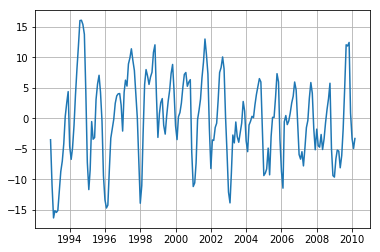

In [10]:
# Now plot with date as the x-axis (and add a grid)
plt.plot(date,data)
plt.grid()

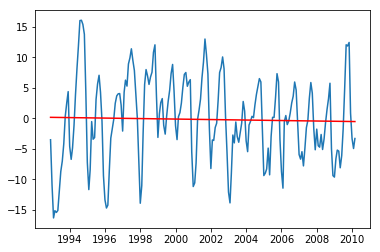

In [20]:
# next step is to fit a line, just line we did with the tide gauges
t = np.arange(0,len(time))
B = np.polyfit(t,data,1)
# convert trend in cm/month to cm/decade
trend = B[0]  * 12.0 * 10.0
# cheap way to round to two digits
trend = int(trend*100.0)/100.0
Y = np.polyval(B,t)
plt.plot(date,data)
plt.plot(date,Y,'r')